# Bag of Words Meets Bags of Popcorn - Sentiment Analysis

## 1. Importing Necessary Libraries

In [1]:
# utilities
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import re
import os
import pickle
import random

# plotting and visualizing
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns


# sklearn

 # classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

 # metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

 # pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

## 2. Preprocessing

### Extracting zip files

In [2]:
from zipfile import ZipFile

with ZipFile("../input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip","r") as z:
    z.extractall(".")
    
with ZipFile("../input/word2vec-nlp-tutorial/testData.tsv.zip","r") as z:
    z.extractall(".")
    
print(os.listdir("/kaggle/working/"))

['__notebook_source__.ipynb', 'labeledTrainData.tsv', 'testData.tsv']


### Loading the train and test data

In [3]:
path_train = "/kaggle/working/labeledTrainData.tsv"
path_test = "/kaggle/working/testData.tsv"

df_train = pd.read_csv(path_train, delimiter = "\t")
df_test = pd.read_csv(path_test, delimiter = "\t")

## 3. Exploratory Data Analysis

In [4]:
df_train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
df_test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [6]:
df_train.shape, df_test.shape

((25000, 3), (25000, 2))

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


## 4. Data Visualization

### Let's look at the each number of sentiment 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

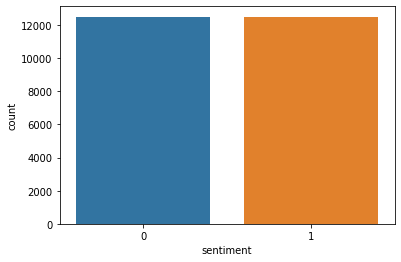

In [8]:
sns.countplot(df_train["sentiment"])

### There are same numbers of target. The dataset is balanced.

## 5. NLP Preprocessing

### Here we create a 0 to 24999 number list.

In [9]:
num_list = list(range(25000))

### Here we chose random number from the list.

In [10]:
i = random.choice(num_list)
df_train["review"].iloc[i]

'Clever, gritty, witty, fast-paced, sexy, extravagant, sleazy, erotic, heartfelt and corny, Footlight Parade is a first-class entertainment, what the movies are all about.<br /><br />The realistic, satirical treatment gives a fresh edge to the material and its pace and line delivery are breathtaking. To think that they only started making feature talking pictures 7 years before this! The brilliance of the dialogue cannot be matched anywhere today, especially considering that \\realism\\" has taken over and engulfed contemporary cinema.<br /><br />This film was made at a time when the Hayes code restricting content was being ignored and the result is a fresh, self-referential, critical and living cinema that spoke directly to contemporary audiences suffering through the depression and the general angst of the age. I\'d recommend watching any film from this period, that is 1930-1935, for a vision of what popular cinema can potentially be."'

In [11]:
i = random.choice(num_list)
df_train["review"].iloc[i]

'More wide-eyed, hysterical 50s hyper-cheerfulness that gives new meaning to anti-social, pathological behaviour. Danza and Grayson will leave you begging for mercy.<br /><br />It\'s a shame that all the people involved in the making of this movie are now dead (or in nursing homes). I kinda thought about suing them for torture. As this movie started unleashing its shamelessly aggressive operatic assault onto my poor, defenseless ear-drums, I felt instant, strong pain envelop my entire being. That damn muscular vibrato can shatter Soviet tanks into tiny bits, nevermind glass.<br /><br />\\Why didn\'t you switch the channel if you didn\'t like it?\\", you might ask angrily. Fair point, fair point... The answer is that I wanted to, but the pain was so sudden and excruciating that I fell to the floor, writhing in agony. With my last ounces of energy, I tried to reach the remote but couldn\'t.<br /><br />A silly little fisherman with the questionable talent of singing with an annoying opera

### I observe some html tags in text, so i clean it.

In [12]:
df_train["review"] = df_train["review"].str.replace("<br />","")

### Here we are doing preprocessing, we are cleaning the text. First we define stop_words list, stemmer and cleaning regex expression. After we do the following: first we clean the text with cleaning regex expression and we converted all text to lowercase. After we use strip() function to delete line breaks (\n). Then we define a empty tokens list. We go over text and tokenize the text. And if token not in stop_words list we take the token and append to the tokens list. And if stem = True is given to us in function calling, we stem the token. Finally we join the tokens and make it a sentence.

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

cleaning = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem = False):
    # Remove link,user and special characters
    text = re.sub(cleaning, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
df_train.review = df_train.review.apply(lambda x: preprocess(x, stem = True))

### We've eliminated accents

In [15]:
from unicodedata import normalize
df_train["review"] = df_train["review"].apply(lambda text: normalize("NFKD", str(text)).encode("ascii", "ignore").decode("utf-8", "ignore"))

### We are deciding x and y and we split it to x_train and x_test

In [16]:
x = df_train.review

y = df_train.sentiment

print(x.shape, y.shape) 

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42)

(25000,) (25000,)


## 6. Predicting and Modeling

### Evaluating Function

In [17]:
def evaluate(model, vect):
    model.fit(x_train_dtm, y_train)
    y_pred = model.predict(x_test_dtm)
    print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print("F1 Score: ", metrics.f1_score(y_test, y_pred))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

### Vectorizing and transforming x_train and x_test

In [18]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 2)

x_train_dtm = tfidf_vect.fit_transform(x_train)
x_test_dtm = tfidf_vect.transform(x_test)

### Defining the Models and Evaluating

In [19]:
MNB = MultinomialNB()
LSVC = LinearSVC()
LR = LogisticRegression(C = 2, max_iter = 1000)
GNB = GaussianNB()
BNB = BernoulliNB()
KNC = KNeighborsClassifier()
SVC = SVC()
DTC = DecisionTreeClassifier()
RFC = RandomForestClassifier()
GBC = GradientBoostingClassifier()

print("Multinomial Classfier: \n")
evaluate(MNB, tfidf_vect)
print("\n")
print("Linear SVC Classfier: \n")
evaluate(LSVC, tfidf_vect)
print("\n")
print("Logistic Regression Classfier: \n")
evaluate(LR, tfidf_vect)
print("\n")
print("Bernoulli Classfier: \n")
evaluate(BNB, tfidf_vect)
print("\n")
print("K Neighbors Classfier: \n")
evaluate(KNC, tfidf_vect)
print("\n")
print("SVC Classfier: \n")
evaluate(SVC, tfidf_vect)
print("\n")
print("Decision Tree Classfier: \n")
evaluate(DTC, tfidf_vect)
print("\n")
print("Random Forest Classfier: \n")
evaluate(RFC, tfidf_vect)
print("\n")
print("Gradient Boosting Classfier: \n")
evaluate(GBC, tfidf_vect)
print("\n")

Multinomial Classfier: 

Accuracy:  0.87728
F1 Score:  0.8784276430496116
Confusion Matrix: 
 [[2712  380]
 [ 387 2771]]


Linear SVC Classfier: 

Accuracy:  0.8984
F1 Score:  0.9004233965814646
Confusion Matrix: 
 [[2744  348]
 [ 287 2871]]


Logistic Regression Classfier: 

Accuracy:  0.89184
F1 Score:  0.8941765810895429
Confusion Matrix: 
 [[2718  374]
 [ 302 2856]]


Bernoulli Classfier: 

Accuracy:  0.87136
F1 Score:  0.8701969648046498
Confusion Matrix: 
 [[2751  341]
 [ 463 2695]]


K Neighbors Classfier: 

Accuracy:  0.796
F1 Score:  0.8089887640449439
Confusion Matrix: 
 [[2275  817]
 [ 458 2700]]


SVC Classfier: 

Accuracy:  0.89392
F1 Score:  0.8964871194379391
Confusion Matrix: 
 [[2716  376]
 [ 287 2871]]


Decision Tree Classfier: 

Accuracy:  0.71552
F1 Score:  0.7187598861119897
Confusion Matrix: 
 [[2200  892]
 [ 886 2272]]


Random Forest Classfier: 

Accuracy:  0.85728
F1 Score:  0.85818759936407
Confusion Matrix: 
 [[2659  433]
 [ 459 2699]]


Gradient Boosting Cl

### We have achieved to high accuracy as 90% in Linear SVC Classifier.

### Creating Wordcloud

In [20]:
def create_wordcloud(text):
    stopwords = set(STOPWORDS)
    wc = WordCloud(max_words = 25000, stopwords = stopwords)
    wc.generate(str(text))
    wc.to_file("wordcloud.png")
    print("Word Cloud saved successfully")
    path = "wordcloud.png"
    display(Image.open(path))

Word Cloud saved successfully


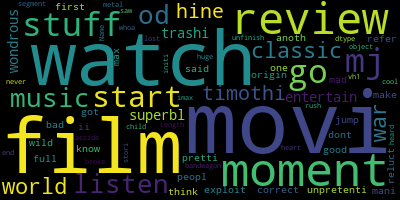

In [21]:
create_wordcloud(df_train[df_train["sentiment"] == 1].review) # positive

Word Cloud saved successfully


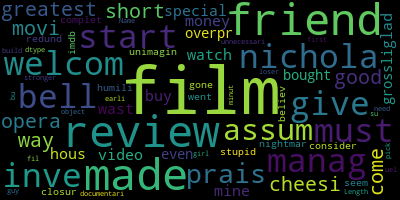

In [22]:
create_wordcloud(df_train[df_train["sentiment"] == 0].review) # negative

## 7. Creating Pipeline

In [23]:
model = Pipeline([("vectorizer", tfidf_vect), ("classifier", LSVC)])
model.fit(x_train, y_train)
pred = model.predict(x_test)
confusion_matrix(pred, y_test)

array([[2744,  287],
       [ 348, 2871]])

In [24]:
def predict(sentence):
    if model.predict(sentence) == 0:
        print("negative")
    else:
        print("positive")

In [25]:
ex = ["It is so nice"]
predict(ex)

positive


In [29]:
ex = ["This is so bad"]
predict(ex)

negative


### Saving the best Model

In [26]:
with open("model_pickle", "wb") as f:
    pickle.dump(LSVC, f)

### Loading the Model


In [27]:
with open("model_pickle", "rb") as f:
    loaded_model = pickle.load(f)

In [28]:
loaded_model.predict(x_test_dtm)

array([0, 1, 0, ..., 0, 1, 1])

#### As you can see, we could save the model and load the model and use it